# ITC data processing

This notebook performs analyses described in the 

**Manuscript:**

Modelling the decamerisation cycle of PRDX1 and the inhibition-like effect on its peroxidase activity

**Authors:**

C. Barry, C. Pillay, J. Rohwer

**Purpose:**

Process ITC data digitized from Barranco-Medina et al. 2008 

Writes processed PRDX1 data (filename: `ITC_data_PRDX1_processed.csv`)

Plot: Figure S1

**Requirements:**

Python libraries (see **Imports** below)

PRDX1 ITC data (filename: `ITC_data_PRDX1.csv`)

##### Imports

In [1]:
import os
import math

import numpy as np
from lmfit import minimize, Parameters, Parameter, report_fit
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import auc
from scipy.interpolate import interp1d

import pysces


Matplotlib backend set to: "nbAgg"
Matplotlib interface loaded (pysces.plt.m)
Pitcon routines available
NLEQ2 routines available
SBML support available
You are using NumPy (1.23.5) with SciPy (1.9.3)
Assimulo CVode available
RateChar is available
Parallel scanner is available

PySCeS environment
******************
pysces.model_dir = /home/chris/Pysces/psc
pysces.output_dir = /home/chris/Pysces


***********************************************************************
* Welcome to PySCeS (1.0.3) - Python Simulator for Cellular Systems   *
*                http://pysces.sourceforge.net                        *
* Copyright(C) B.G. Olivier, J.M. Rohwer, J.-H.S. Hofmeyr, 2004-2022  *
* Triple-J Group for Molecular Cell Physiology                        *
* Stellenbosch University, ZA and VU University Amsterdam, NL         *
* PySCeS is distributed under the PySCeS (BSD style) licence, see     *
* LICENCE.txt (supplied with this release) for details                *
* Please cite PySCeS with

###### Get directory paths

In [2]:
prev_dir = os.path.split(os.getcwd())[0]

mod_dir = os.path.join(prev_dir,"models")
if not os.path.isdir(mod_dir): os.mkdir(mod_dir) # ensure dir exists
    
fig_dir = os.path.join(os.getcwd(),"Figures")
if not os.path.isdir(fig_dir): os.mkdir(fig_dir) # ensure dir exists


###### Matplotlib stuff

In [3]:
%matplotlib inline

multiplier = 1
mpl_width = 4.5*multiplier
mpl_height = 3.5*multiplier
mpl_dpi = 600
mpl_xlabel_fontsize = "large"
mpl_ylabel_fontsize = "large"
mu = "\u03bc"

## Barranco-Medina PRDX1 Data

<AxesSubplot: xlabel='Time (min)'>

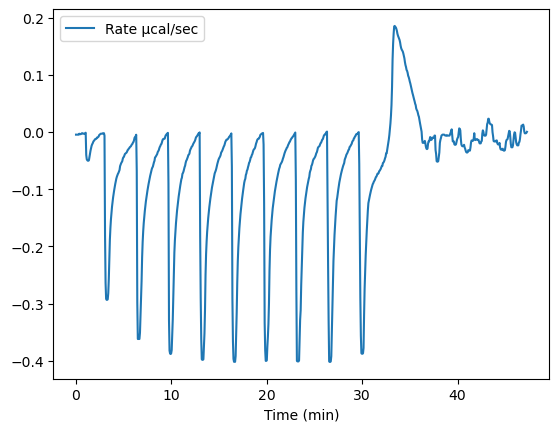

In [4]:
df_PRDX1 = pd.read_csv('ITC_data_PRDX1.csv', names = ["Time (min)", f"Rate {mu}cal/sec"], sep = ",",index_col=0)
df_PRDX1 = df_PRDX1.reset_index().drop_duplicates(subset='Time (min)', keep='last').set_index('Time (min)').sort_index()

df_PRDX1.plot() 

In [5]:
# Convert x-data to seconds
df_PRDX1_orig = df_PRDX1.copy()
df_PRDX1.index = df_PRDX1.index*60
df_PRDX1.index.names = ['Time (sec)']


<AxesSubplot: xlabel='Time (sec)'>

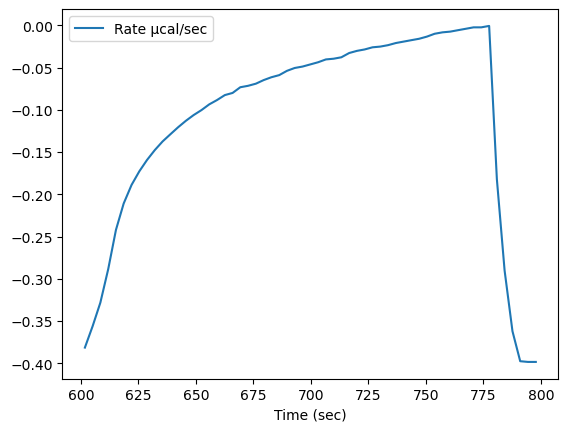

In [6]:
# View a peak
inject_num = 3
df_PRDX1.loc[(inject_num*200):(inject_num*200+200)].plot()

### Process PRDX1 data

#### Subtract delay and first data point

<AxesSubplot: xlabel='Time (sec)'>

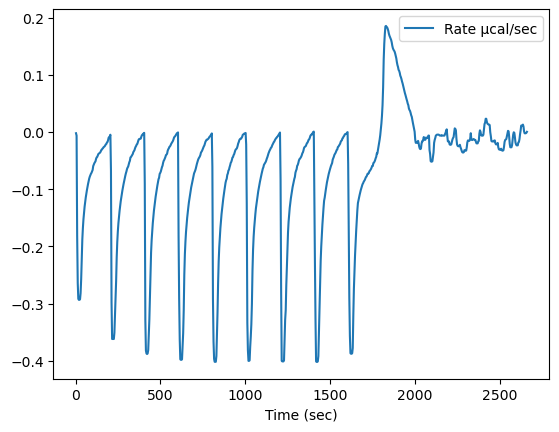

In [7]:
start_delay = 174.00
df_PRDX1_post_delay = df_PRDX1[start_delay:].copy()
df_PRDX1_post_delay.index = df_PRDX1_post_delay.index - start_delay
df_PRDX1_post_delay.plot()

In [8]:
df_PRDX1 = df_PRDX1_post_delay.copy()

#### Visualize overlayed peaks to confirm injection interval

In [9]:
injection_interval = 200.0
num_injections = math.floor(df_PRDX1.index[-1]/injection_interval)
data_split_by_injection = []

count = 0
while count < num_injections:
    start = count*injection_interval
    end = start + injection_interval
    df_split = pd.DataFrame(df_PRDX1.loc[start: end])
    data_split_by_injection.append(df_split)
    count += 1

/tmp/ipykernel_88453/3159565482.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


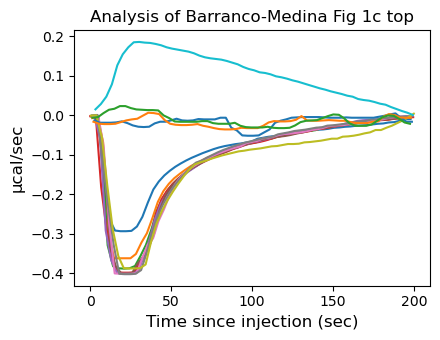

In [10]:
rows = 1
cols =1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

for count,df_subset in enumerate(data_split_by_injection):
    axarr.plot(df_subset.index - count*injection_interval,df_subset['Rate μcal/sec'])
axarr.set_xlabel(f'Time since injection (sec)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'{mu}cal/sec',fontsize = mpl_ylabel_fontsize)
axarr.set_title("Analysis of Barranco-Medina Fig 1c top")

f.tight_layout()
f.show()

/tmp/ipykernel_88453/3560570110.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


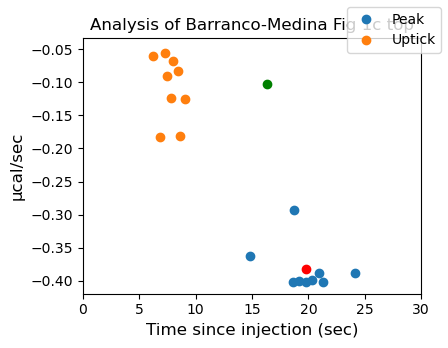

In [11]:
rows = 1
cols =1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

peak_xs = []
peak_ys = []
for count,df_subset in enumerate(data_split_by_injection):
    peak_loc = df_subset['Rate μcal/sec'].idxmin()
    if df_subset['Rate μcal/sec'][peak_loc] < -0.1:
        peak_xs.append((peak_loc - count*injection_interval))
        peak_ys.append(df_subset.loc[peak_loc,'Rate μcal/sec'])
axarr.plot(peak_xs,peak_ys, "o", label = "Peak")
axarr.plot(sum(peak_xs)/len(peak_xs),sum(peak_ys)/len(peak_ys), "ro")

uptick_xs = []
uptick_ys = []
for count,df_subset in enumerate(data_split_by_injection):
    uptick_loc = df_subset[df_subset['Rate μcal/sec']<-0.05]
    if uptick_loc.empty != True:
        uptick_loc = uptick_loc.index[0]
        uptick_xs.append((uptick_loc - count*injection_interval))
        uptick_ys.append(df_subset.loc[uptick_loc,'Rate μcal/sec'])
axarr.plot(uptick_xs,uptick_ys, "o", label = "Uptick")
axarr.plot(sum(uptick_xs)/len(uptick_xs),sum(uptick_ys)/len(uptick_ys), "go")

axarr.set_xlim(0,30)
axarr.set_xlabel(f'Time since injection (sec)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'{mu}cal/sec',fontsize = mpl_ylabel_fontsize)
axarr.set_title("Analysis of Barranco-Medina Fig 1c top")

f.legend()
f.tight_layout()
f.show()

#### Laplace Transform (figure S1a and S1b)

<AxesSubplot: xlabel='Time (sec)'>

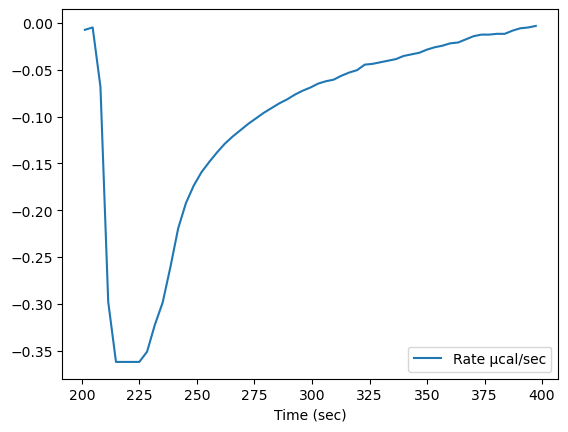

In [12]:
count = 1
start = count*injection_interval
end = start + injection_interval
df_PRDX1.loc[start: end].plot()

In [13]:
num_injections = math.floor(df_PRDX1.index[-1]/injection_interval)
data_split_by_injection = []

count = 0
while count < num_injections:
    start = count*injection_interval
    end = start + injection_interval
    df_split = pd.DataFrame(df_PRDX1.loc[start: end])
    data_split_by_injection.append(df_split)
    count += 1

delay = 20 # From device data or above plot
df_subset = data_split_by_injection[0]
y = df_subset["Rate μcal/sec"]
x = df_subset.index
der = np.gradient(y,x)
y = df_subset["Rate μcal/sec"]+delay*der # Laplace here
df_PRDX1_Lap = pd.DataFrame(y)
data_split_by_injection.pop(0)

for count,df_subset in enumerate(data_split_by_injection):
    y = df_subset["Rate μcal/sec"]
    x = df_subset.index
    der = np.gradient(y,x)
    y = df_subset["Rate μcal/sec"]+delay*der
    df_temp = pd.DataFrame(y)
    df_PRDX1_Lap = pd.concat([df_PRDX1_Lap,df_temp])

/tmp/ipykernel_88453/1701122793.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


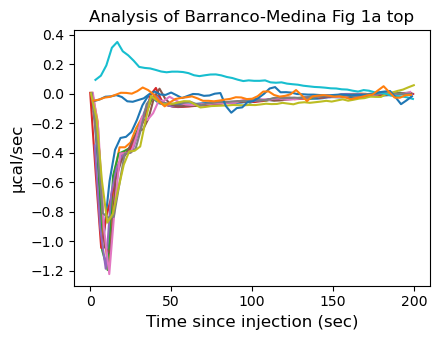

In [14]:
injection_interval = 200.0
num_injections = math.floor(df_PRDX1_Lap.index[-1]/injection_interval)
data_split_by_injection = []

count = 0
while count < num_injections:
    start = count*injection_interval
    end = start + injection_interval
    df_split = pd.DataFrame(df_PRDX1_Lap.loc[start: end])
    data_split_by_injection.append(df_split)
    count += 1

rows = 1
cols =1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

for count,df_subset in enumerate(data_split_by_injection):
    axarr.plot(df_subset.index - count*injection_interval,df_subset['Rate μcal/sec'])
axarr.set_xlabel(f'Time since injection (sec)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'{mu}cal/sec',fontsize = mpl_ylabel_fontsize)
axarr.set_title("Analysis of Barranco-Medina Fig 1a top")

f.tight_layout()
f.show()

/tmp/ipykernel_88453/532279139.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


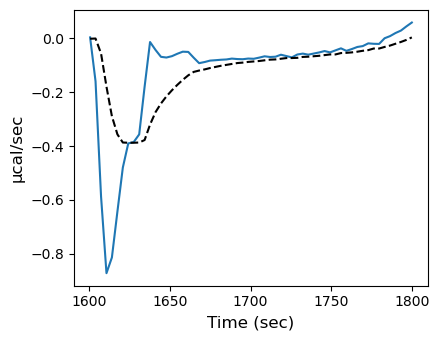

In [15]:
# View a peak
inject_num = 8
# df_PRDX1.loc[(inject_num*180):(inject_num*180+180)].plot()

start = inject_num*injection_interval
end = start + injection_interval

rows = 1
cols =1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

axarr.plot(df_PRDX1_Lap.loc[start: end].index,df_PRDX1_Lap.loc[start: end]['Rate μcal/sec'])

axarr.plot(df_PRDX1.loc[start: end].index,df_PRDX1.loc[start: end]['Rate μcal/sec'], "k--")
    
axarr.set_xlabel(f'Time (sec)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'{mu}cal/sec',fontsize = mpl_ylabel_fontsize)
# axarr.set_title("Analysis of Barranco-Medina Fig 1a top")

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"ITC_process_Lap_Orig_vs_time.pdf"),dpi= mpl_dpi)

/tmp/ipykernel_88453/3143539916.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


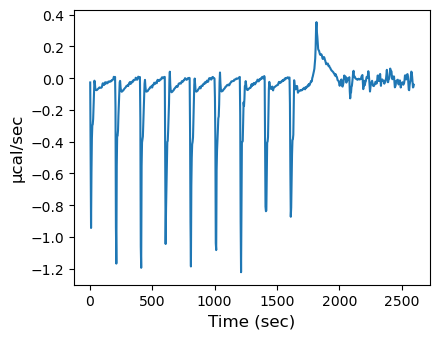

In [16]:
rows = 1
cols =1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

axarr.plot(df_PRDX1_Lap.index,df_PRDX1_Lap['Rate μcal/sec'])
    
axarr.set_xlabel(f'Time (sec)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'{mu}cal/sec',fontsize = mpl_ylabel_fontsize)
# axarr.set_title("Analysis of Barranco-Medina Fig 1a top")

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"ITC_process_Lap_trace_vs_time.pdf"),dpi= mpl_dpi)

In [17]:
df_PRDX1 = df_PRDX1_Lap.copy()

#### Intrepolate at x integer points

In [18]:
interp_exp_data = np.zeros((math.floor(df_PRDX1.index[-2]),2))

for count,xy_point in enumerate(interp_exp_data):
    if count == len(interp_exp_data):
        break    
    if count+1 <= df_PRDX1.index.min():
        x2 = 0.0
        y2 = df_PRDX1.iloc[0]
    else:
        x2 = df_PRDX1.index[df_PRDX1.index<count+1][-1]
        y2 = df_PRDX1.loc[x2]["Rate μcal/sec"]
    
    x1 = df_PRDX1.index[df_PRDX1.index>count+1][0]
    y1 = df_PRDX1.loc[x1]["Rate μcal/sec"]
    y_interp = interp1d([x1,x2], [y1,y2])(count+1)
    interp_exp_data[count,0] = count+1
    interp_exp_data[count,1] = y_interp
    
df_PRDX1_interp = pd.DataFrame(interp_exp_data, columns = ["Time (sec)", f"Rate {mu}cal/sec"])
df_PRDX1_interp['Time (sec)'] = np.rint(df_PRDX1_interp['Time (sec)']).astype(int)
df_PRDX1_interp = df_PRDX1_interp.drop_duplicates(subset='Time (sec)', keep='first').set_index('Time (sec)')

/home/chris/anaconda3/envs/phd/lib/python3.9/site-packages/scipy/interpolate/_polyint.py:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  yi = np.asarray(yi)
/home/chris/anaconda3/envs/phd/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:463: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = array(y, copy=self.copy)


/tmp/ipykernel_88453/53356658.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


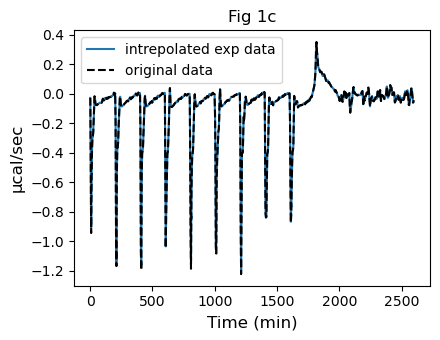

In [19]:
rows = 1
cols =1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

axarr.plot(df_PRDX1_interp.index,df_PRDX1_interp["Rate μcal/sec"], label = "intrepolated exp data")
axarr.plot(df_PRDX1.index, df_PRDX1["Rate μcal/sec"],"k--", label = "original data")

axarr.set_xlabel(f'Time (min)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'{mu}cal/sec',fontsize = mpl_ylabel_fontsize)
axarr.set_title(f"Fig 1c")
axarr.legend()

f.tight_layout()
f.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_88453/334726392.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


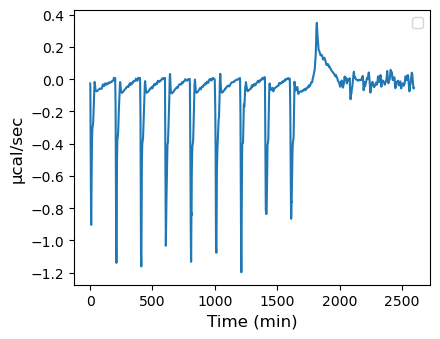

In [20]:
rows = 1
cols =1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

axarr.plot(df_PRDX1_interp.index,df_PRDX1_interp["Rate μcal/sec"])

axarr.set_xlabel(f'Time (min)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'{mu}cal/sec',fontsize = mpl_ylabel_fontsize)
axarr.legend()

f.tight_layout()
f.show()
# f.savefig(os.path.join(fig_dir,"BM_At_Laplace_v_time.pdf"),dpi= mpl_dpi)

/tmp/ipykernel_88453/1546553746.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


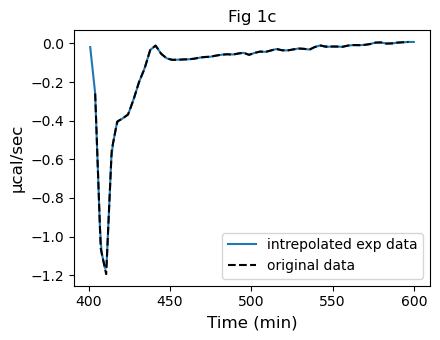

In [21]:
inject_num = 2
start = inject_num*int(injection_interval)+1
stop = inject_num*int(injection_interval) + int(injection_interval)

rows = 1
cols =1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

axarr.plot(df_PRDX1_interp.loc[start:stop].index,df_PRDX1_interp.loc[start:stop], label = "intrepolated exp data")
axarr.plot(df_PRDX1.loc[start:stop].index, df_PRDX1.loc[start:stop]["Rate μcal/sec"],"k--", label = "original data")

axarr.set_xlabel(f'Time (min)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'{mu}cal/sec',fontsize = mpl_ylabel_fontsize)
axarr.set_title(f"Fig 1c")
axarr.legend()

f.tight_layout()
f.show()

In [22]:
df_PRDX1 = df_PRDX1_interp.copy()

#### Dissociation injections only

<AxesSubplot: xlabel='Time (sec)'>

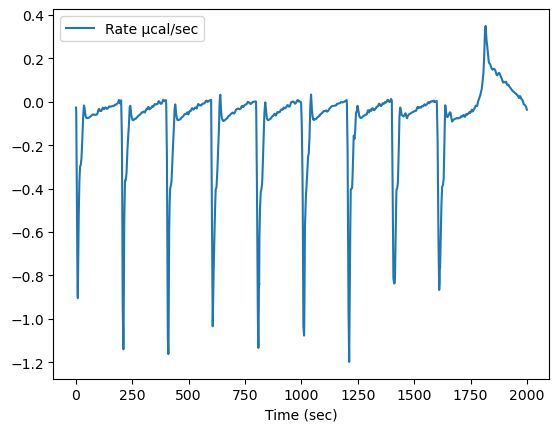

In [23]:
num_disso_injections = 10

start = 0
end = injection_interval
df_PRDX1_disso = pd.DataFrame(df_PRDX1.loc[start: end])

count = 1
while count <= num_disso_injections-1: # First injection is at 0
    start = count*injection_interval
    end = start + injection_interval
    df_temp = pd.DataFrame(df_PRDX1.loc[start: end])
    df_PRDX1_disso = pd.concat([df_PRDX1_disso,df_temp])
    count += 1
    
df_PRDX1_disso.plot()

In [24]:
df_PRDX1 = df_PRDX1_disso.copy()

#### Normalize to AUC  (figure S1c)

In [25]:
num_disso_injections = math.floor(df_PRDX1.index[-1]/injection_interval)

start = 0
end = injection_interval
df_temp = pd.DataFrame(df_PRDX1.loc[start: end])
area = np.abs(np.trapz(df_temp.values.flatten(),df_temp.index))
print(area)
df_PRDX1_AUCnorm = df_temp/area

count = 1
while count < num_disso_injections:
    start = count*injection_interval
    end = start + injection_interval
    df_temp = pd.DataFrame(df_PRDX1.loc[start: end])
    area = np.abs(np.trapz(df_temp.values.flatten(),df_temp.index))
    print(area)
    df_temp = df_temp/area
    df_PRDX1_AUCnorm = pd.concat([df_PRDX1_AUCnorm,df_temp])
    count += 1

18.292890598785178
20.561521400250907
22.065516346106143
23.015108252928147
23.306760927625614
22.468269906695905
22.14252791646626
21.764905520199278
24.40163469780134
19.679893615816034


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_88453/238518033.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


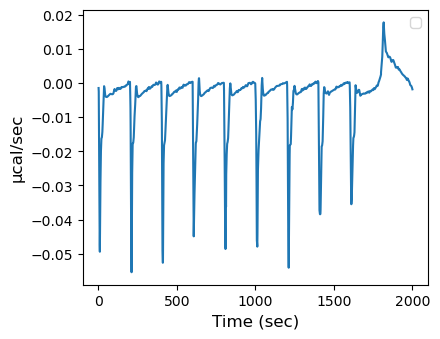

In [26]:
rows = 1
cols =1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

axarr.plot(df_PRDX1_AUCnorm.index, df_PRDX1_AUCnorm["Rate μcal/sec"])

axarr.set_xlabel(f'Time (sec)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'{mu}cal/sec',fontsize = mpl_ylabel_fontsize)
# axarr.set_title(f"Fig 1a")
axarr.legend()

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"ITC_process_AUCnorm_vs_time.pdf"),dpi= mpl_dpi)

In [27]:
df_PRDX1 = df_PRDX1_AUCnorm.copy()

#### Filter out pre-delay data (figure S1d)

<AxesSubplot: xlabel='Time (sec)'>

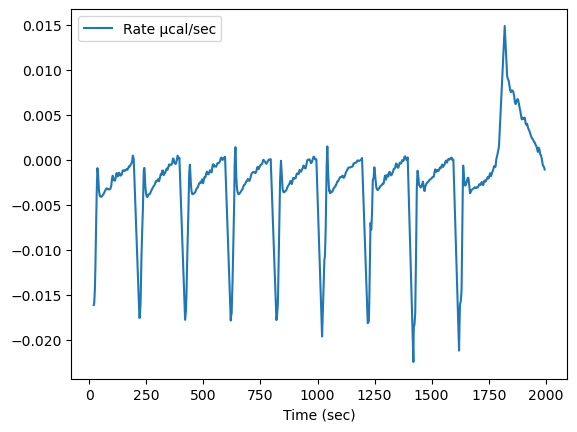

In [28]:
num_injections = math.floor(df_PRDX1_AUCnorm.index[-1]/injection_interval)
data_split_by_injection = []

start = 0
end = injection_interval
df_PRDX1_filtered = pd.DataFrame(df_PRDX1_AUCnorm.loc[start+delay: end-5])

count = 1
while count < num_injections:
    start = count*injection_interval
    end = start + injection_interval
    df_temp = pd.DataFrame(df_PRDX1_AUCnorm.loc[start+delay: end-5])
    df_PRDX1_filtered = pd.concat([df_PRDX1_filtered,df_temp])
    count += 1
    
df_PRDX1_filtered.plot()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_88453/1221771482.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


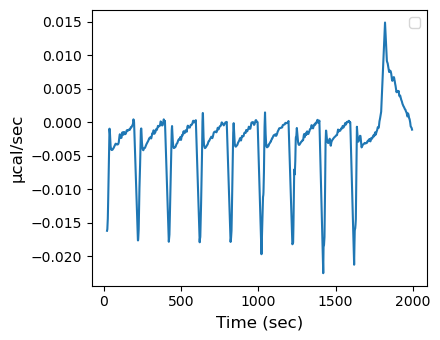

In [29]:
rows = 1
cols =1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

axarr.plot(df_PRDX1_filtered.index, df_PRDX1_filtered["Rate μcal/sec"])

axarr.set_xlabel(f'Time (sec)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'{mu}cal/sec',fontsize = mpl_ylabel_fontsize)
# axarr.set_title(f"Fig 1a")
axarr.legend()

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"ITC_process_filtered_vs_time.pdf"),dpi= mpl_dpi)

### Write processed PRDX1 data

In [30]:
df_PRDX1_filtered.to_csv(os.path.join(os.getcwd(),"ITC_data_PRDX1_processed.csv"), sep=',', encoding='utf-8')